# 0.0 imports

In [2]:
import pandas as pd 
import inflection
import math
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from IPython.display import Image
import datetime

# 0.1 Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading Data

In [6]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False) 
df_store_raw = pd.read_csv('data/store.csv', low_memory = False )


# sobre o parâmetro low_memory, colocando true,
#o comando assimila que o computador tem pouca memória e vai lendo o database aos poucos. 
#como tá false, vai ler tudo de uma vez. 

#merge 

df_raw = pd.merge(df_sales_raw, df_store_raw, how= 'left', on = 'Store')

# 1.0 Descrição dos dados

In [7]:
df1 = df_raw.copy() #conforme o meigarom muda de sessão, ele faz uma cópia do dataset modificado,
#pra caso se altere os dados originais e der algum erro, ele não precise vir dando enter desde o começo do notebook.

In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = df1.columns

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new


# 1.2 Data Dimensions

In [10]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of Cols: 18


# 1.3 Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

# 1.4 Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5 Fillout NA 

In [10]:
#competition_distance     

#Para dar NA em uma distância de competidor provavelmente é porque não tem competidor próximo. Então eu coloco uma distância 
#muito maior do que a máxima distância para preencher os valores NaN, pois assumo que não tem competidor próximo, 
#o mais próximo é longe p crl. 

#competition_open_since_month    
#competition_open_since_year     
#promo2_since_week               
#promo2_since_year               
#promo_interval                  

In [12]:
df1['competition_distance'].max() 

75860.0

In [13]:
#competition_distance 

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition open_since_month

#A presença de concorrência a partir de um momento no tempo influencia muito nas vendas. Pensando na importância, para utilizar
#essa coluna nos modelos, eu vou colocar a data das vendas na mesma, mesmo não fazendo muito sentido.
#Se não der certo, eu outra fase do crisp eu tento algo mais lógico. 

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1) 



In [88]:
df1['date'].dt.month.head()

0    7
1    7
2    7
3    7
4    7
Name: date, dtype: int64

In [15]:
#promo interval - Certamente os NA referem-se a lojas que não participaram da promoção.

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [16]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [18]:
df1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
467889,375,4,2014-05-08,10556,833,1,1,0,0,a,c,15710.0,2.0,2013.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",May,0
527491,882,7,2014-03-16,0,0,0,0,0,0,a,a,30.0,4.0,2013.0,0,11.0,2014.0,0,Mar,0
664594,840,3,2013-11-13,7361,1123,1,0,0,0,a,a,1070.0,9.0,2009.0,0,46.0,2013.0,0,Nov,0
810934,1115,5,2013-07-05,6674,428,1,1,0,0,d,c,5350.0,7.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec",Jul,0
361491,908,3,2014-08-20,4515,379,1,1,0,1,a,a,1980.0,7.0,2010.0,1,37.0,2009.0,"Jan,Apr,Jul,Oct",Aug,0


## 1.6 Change Types

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1.to_csv('C:\\Users\\Matheus\\Desktop\\pc_comunidade_ds_atualizado_31-01\\ds_em_producao\\projeto_ds_em_prod\\df1_tratado.csv')

## Descriptical Statistical

In [5]:
df1 = pd.read_csv('C:\\Users\\Matheus\\Desktop\\pc_comunidade_ds_atualizado_31-01\\ds_em_producao\\projeto_ds_em_prod\\df1_tratado.csv')

C:\Users\Matheus\AppData\Local\Temp\ipykernel_9020\1105137809.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('C:\\Users\\Matheus\\Desktop\\pc_comunidade_ds_atualizado_31-01\\ds_em_producao\\projeto_ds_em_prod\\df1_tratado.csv')


In [6]:
df1.drop(columns = ['Unnamed: 0'], inplace = True)

In [7]:
df1['date'] = pd.to_datetime(df1['date'])

In [8]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [9]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis 

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index() 
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [10]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [11]:
pd.DataFrame(num_attributes.apply(np.std)).T

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,321.908493,1.99739,3849.924283,464.411506,0.375539,0.485758,0.383056,12547.646829,3.311085,5.515591,0.5,14.310057,1.662657,0.362124


## 1.7.2 Categorical Attributes

In [12]:
cat_attributes.apply(lambda x: x.nunique())

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [13]:
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0)] 
#tirando os dias que não teve venda, eu consigo analistar o boxplot melhor 

<Axes: xlabel='assortment', ylabel='sales'>

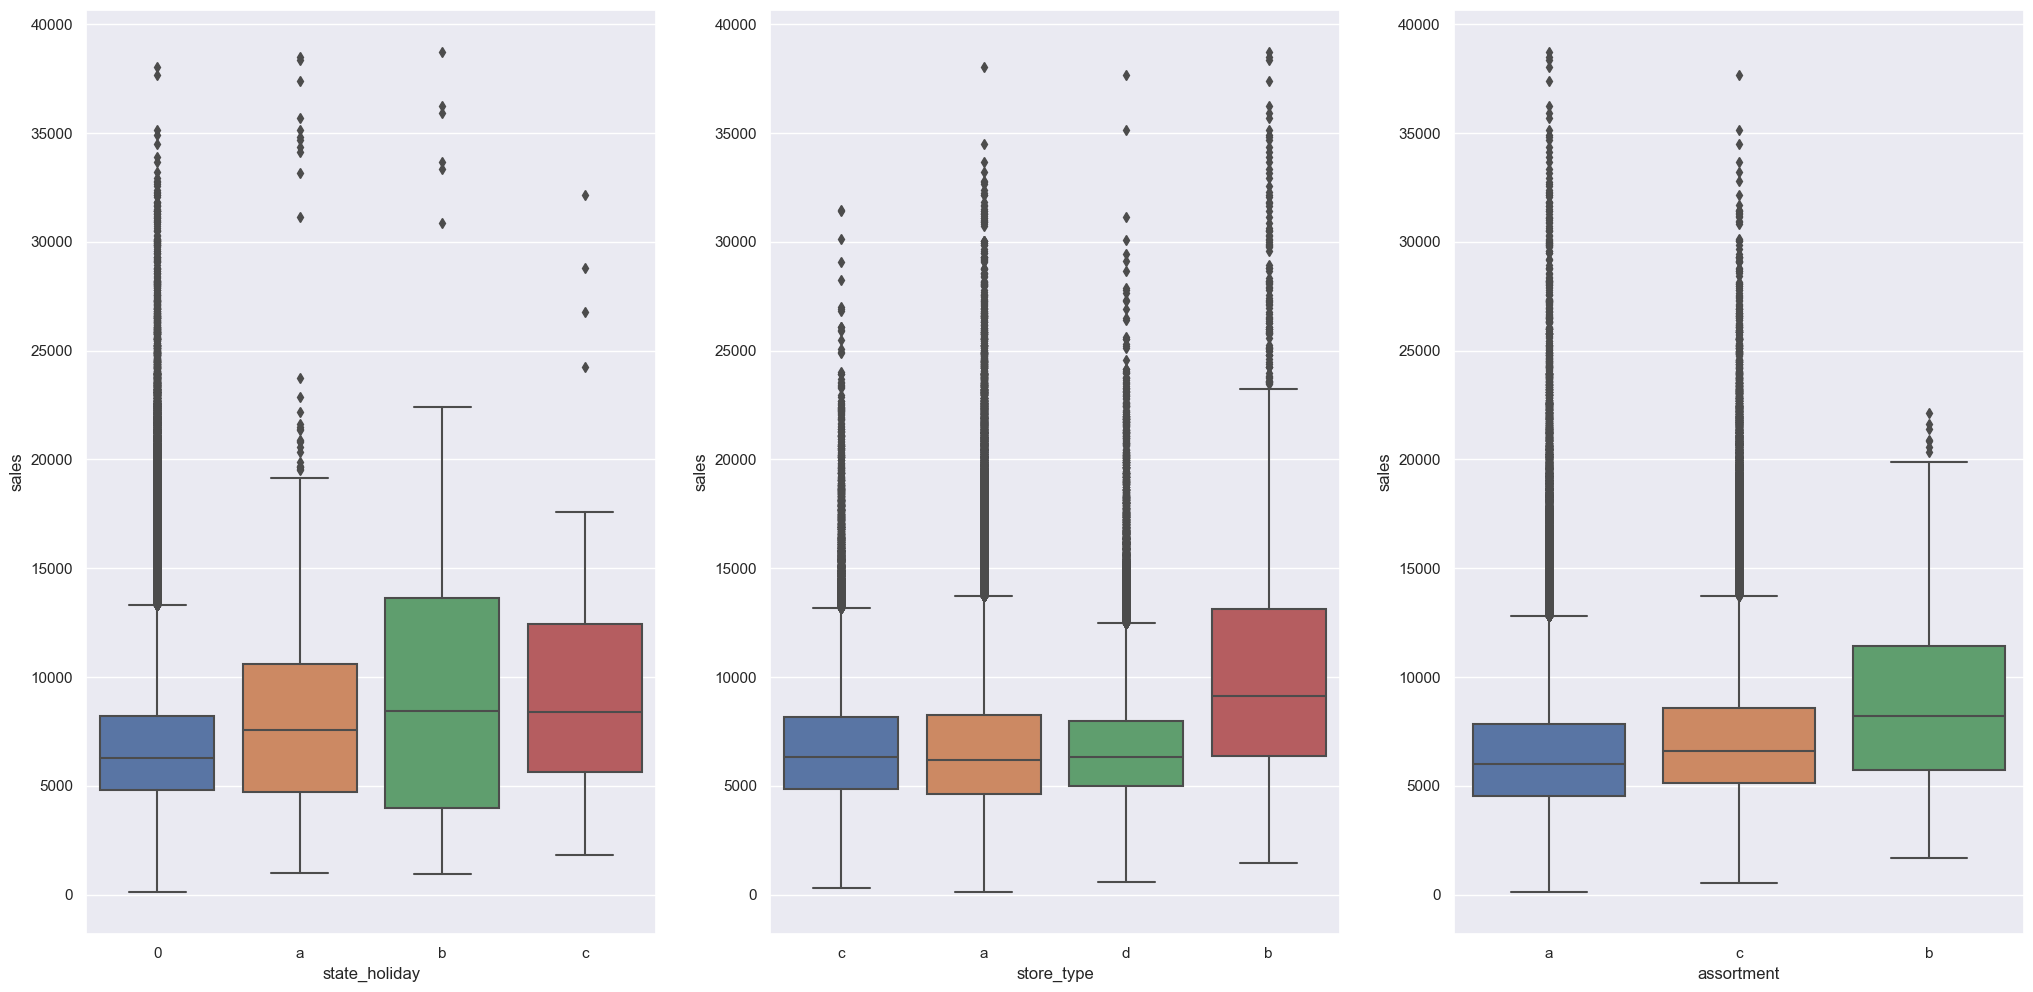

In [14]:
plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y='sales', data = aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x= 'store_type', y = 'sales', data = aux1)

plt.subplot(1, 3, 3) 
sns.boxplot(x= 'assortment', y = 'sales', data = aux1)

## 2.1 Criação das Hipóteses

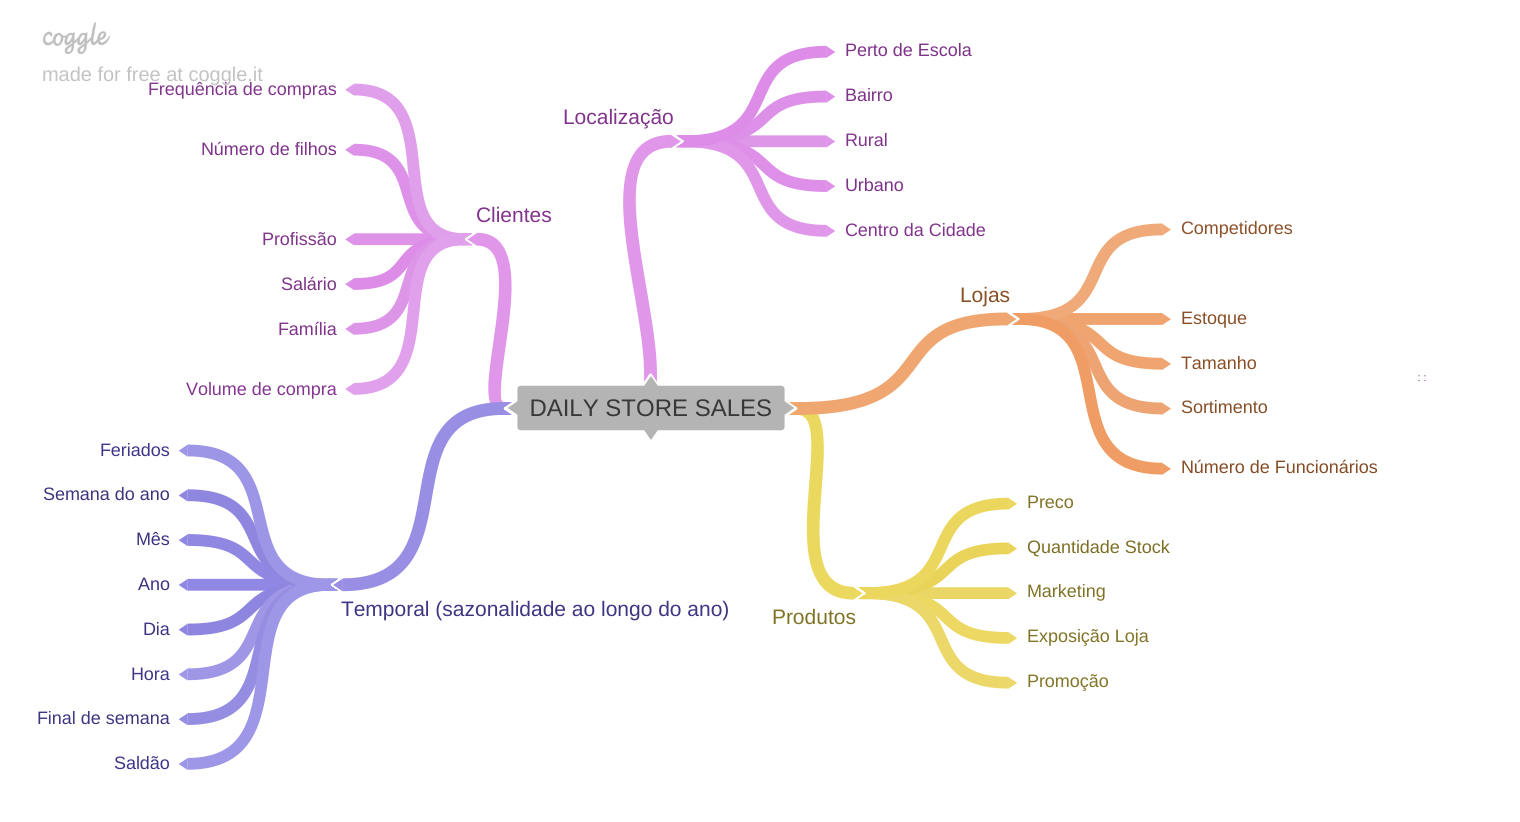

In [13]:
Image( 'img/MindMapHypothesis.png' )

### 2.1.1 Hipóteses Loja 

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

### 2.2 Lista final de hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering

In [15]:
df2 = df1.copy() #só pra manter as mesmas variáveis da forma que o meigarom fez. 


#year
df2['year'] = df2['date'].dt.year 

#month
df2['month'] = df2['date'].dt.month

#day 
df2['day'] = df2['date'].dt.day 

#week of the year 
df2['week_of_year'] = df2['date'].dt.weekofyear

#week of year 
df2['week_of_year'] = df2['date'].dt.strftime('%Y-%W')

#competition since
#estão separadas em colunas de mês e ano. Preciso unir as duas em uma só data. 
#coloco day = 1 para pegar o mês como um todo, desdo primeiro dia. 
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)

df2['competition_time_month'] = (( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int) 

#df2['date'] - df2['competition_since'] = retorna um timedelta que representa a diferença de dias entre duas datas (ex: Timedelta('2524 days 00:00:00'))
#df2['date'] - df2['competition_since']/30 = mas eu quero saber a quantidade de meses, então divido por 30 
#(( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int ) = transforma cada linha da series em NÚMERO.


#promo since

df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

#tem um pdf 'Códigos para formato de datetime para as funções stripftime e striptime' neste repositório.
#tenho dúvida no código acima. 

df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday 
# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


C:\Users\Matheus\AppData\Local\Temp\ipykernel_9020\3012143291.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 - Passo 3 - Filtragem de variáveis

In [16]:
df3 = df2.copy()

In [17]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem de linhas

In [18]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)] 

#só tenho vendas quando a loja estiver aberta. 

## 3.2 Seleção das Colunas

In [19]:
#costumers é uma coluna que se usar ela vamos precisar dela no momento da predição. E baseado no contexto que temos, não temos quanto costumers terão daqui a 6 semanas. 
#Então eu teria que fazer um projeto separado pra fazer previsão de quantos costumers estariam em cada uma das lojas nas próximas 6 semanas, pegar esse resultado e 
#utilizar como input nesse projeto. Costumer é uma coluna que não tenho disponível no momento da predição, então é uma restrição de negócio, eu não consigo utilizar.

#Coluna open de acordo com a filtragem acima da célula acima é sempre 1. 

#As outras colunas são auxiliares. 

cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [20]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'competition_since', 'competition_time_month',
       'promo_since', 'promo_time_week'],
      dtype='object')

# 4.9 Passo 04 - Análise Exploratória dos Dados

In [21]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable 

C:\Users\Matheus\AppData\Local\Temp\ipykernel_9020\2407103643.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'])


<Axes: xlabel='sales', ylabel='Density'>

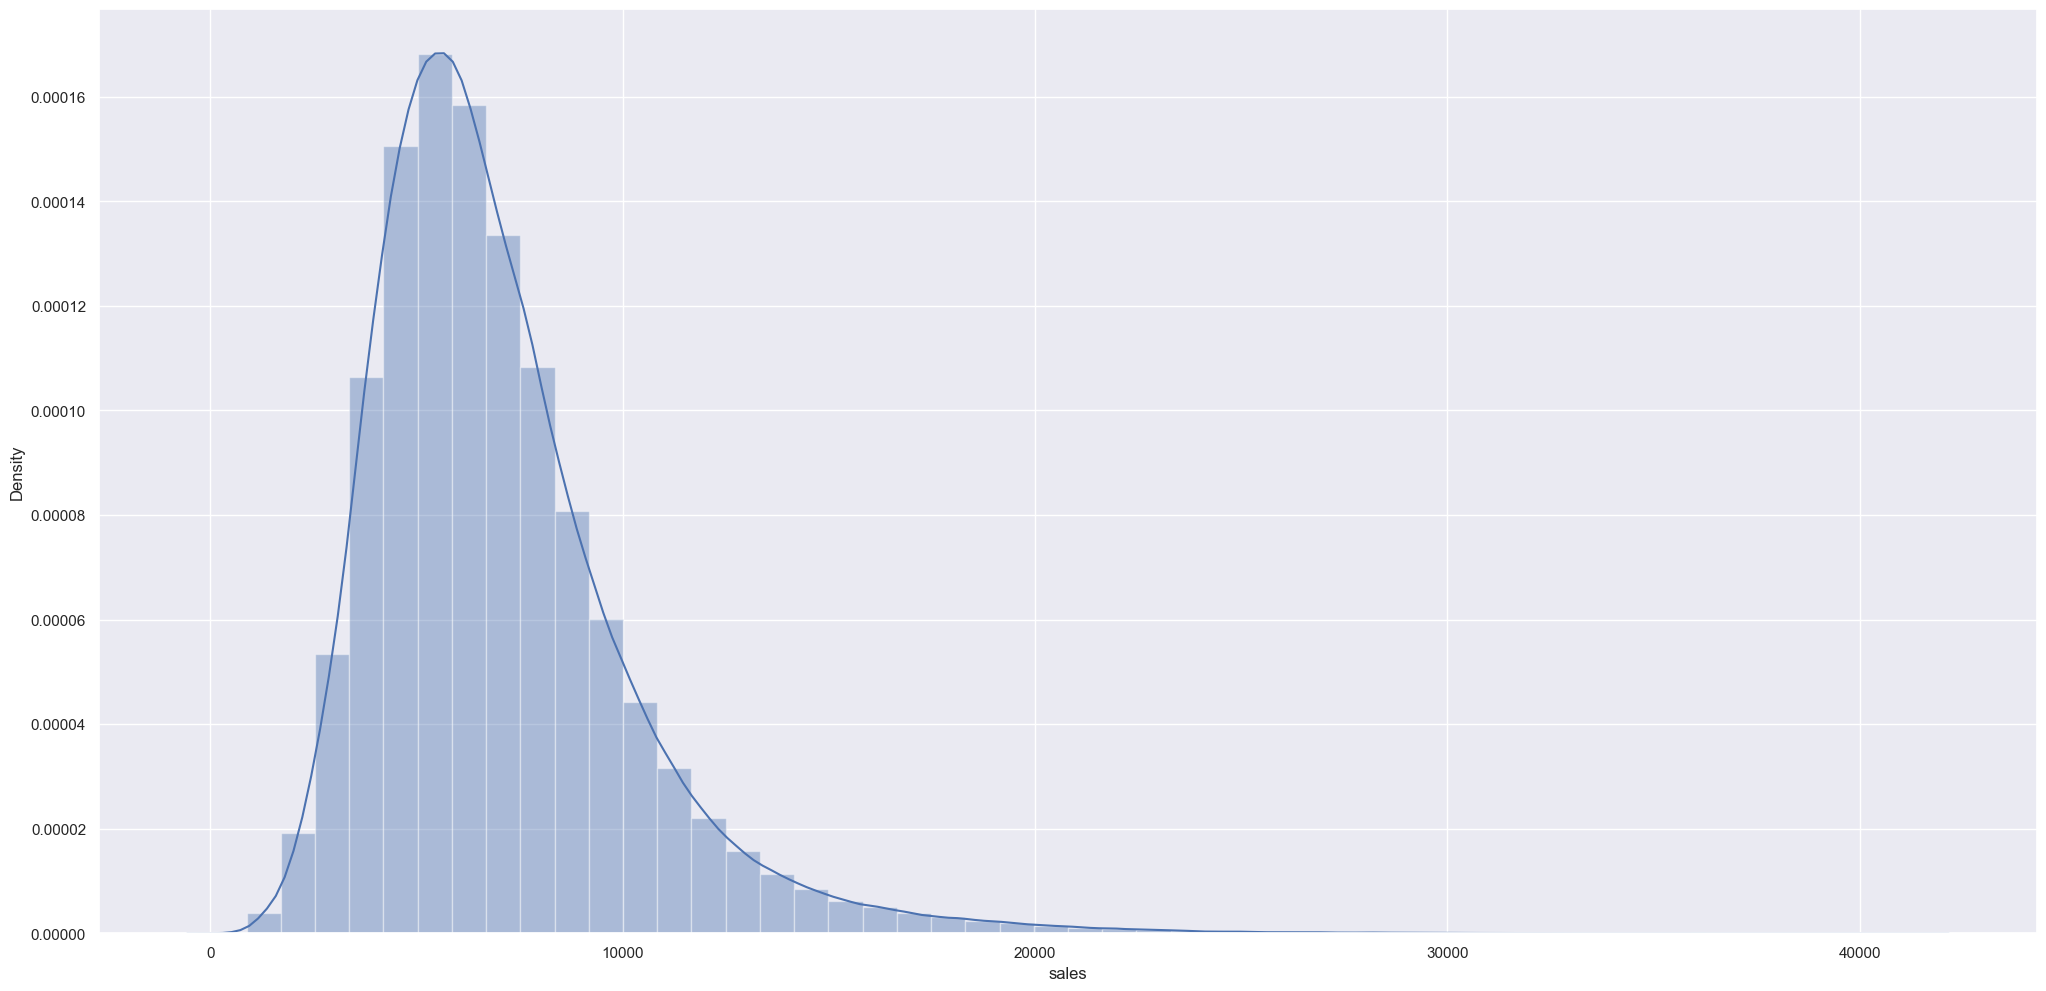

In [22]:
#variável resposta é a sales. 
#quanto mais normal for a distribuição da variável resposta, melhor o algoritmo performará. 


sns.distplot(df4['sales'])

#os números no eixo y  são pequenos, pois isso é um plot de uma densidade de distribuição.
#pro histograma eu preciso colcoar: 

#sns.distplot(df4['sales'], kde = False)


### 4.1.2 Numerical Variable

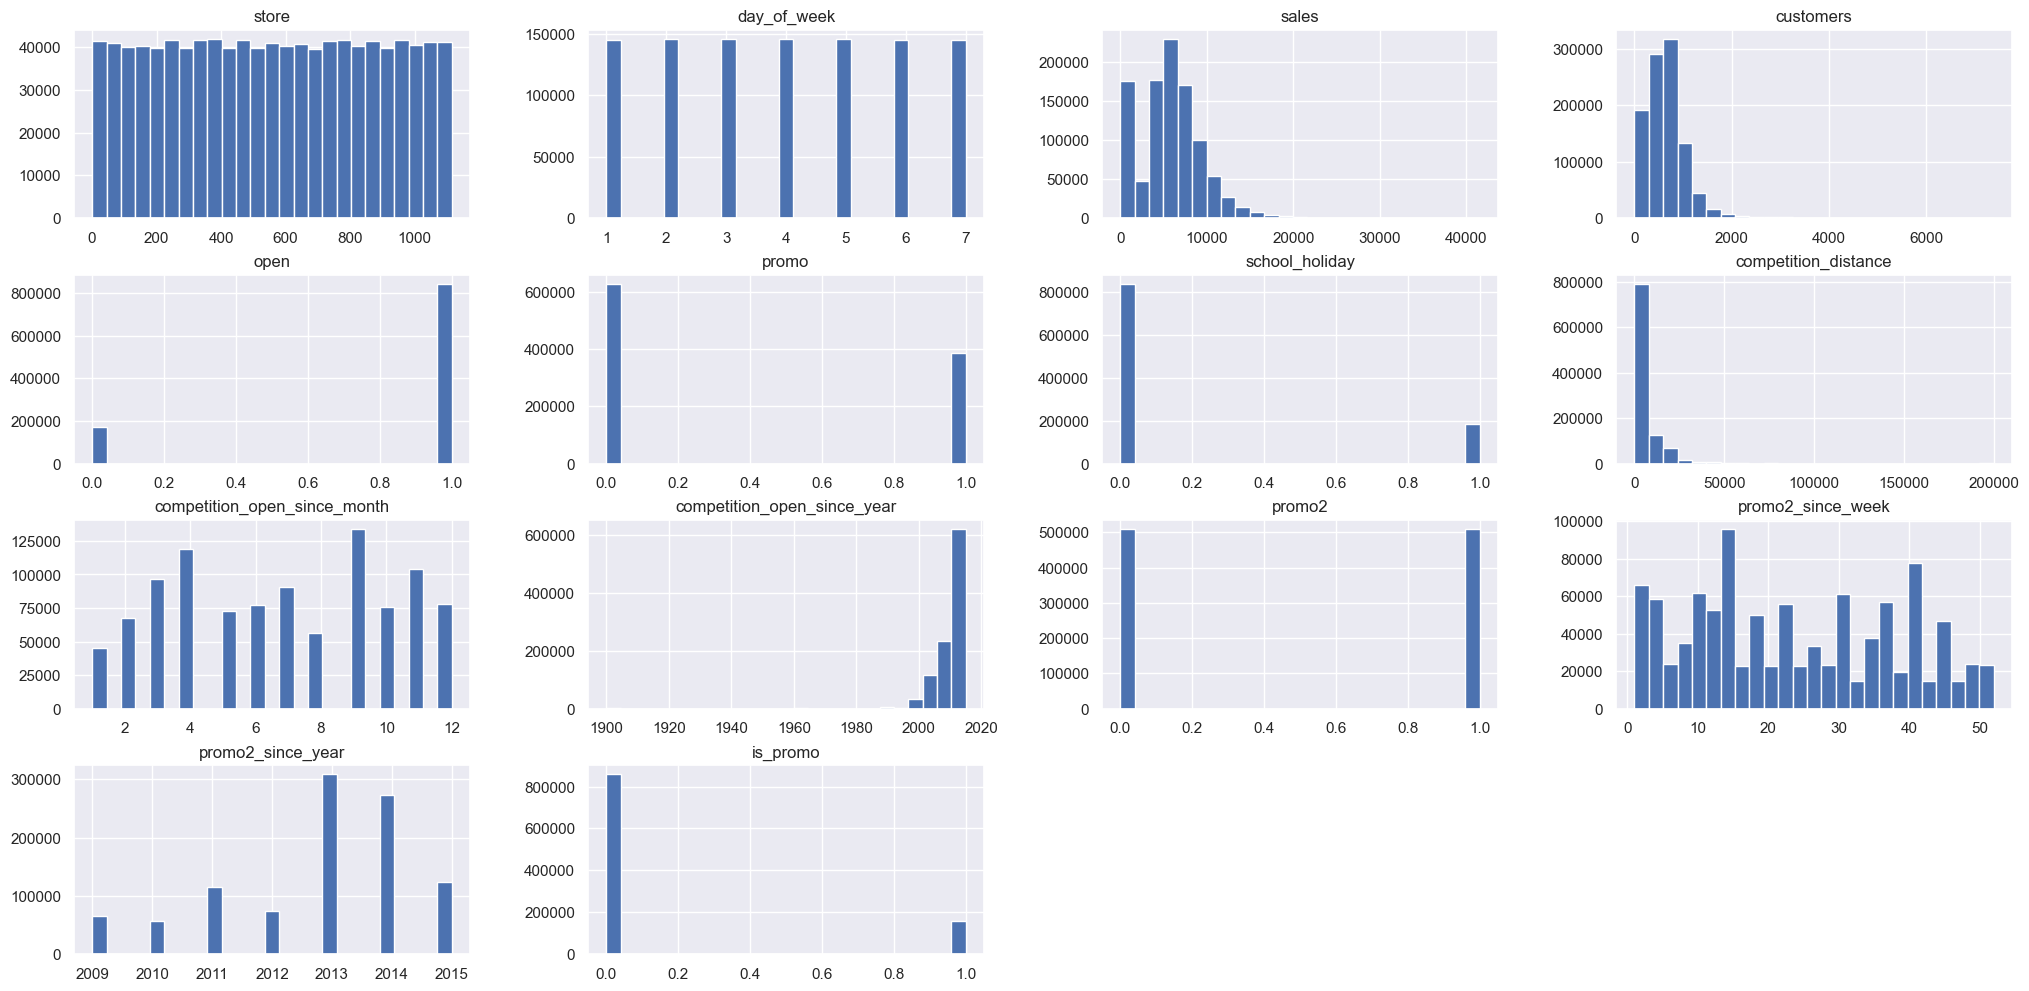

In [22]:
#bin é cada retângulo que tem para demonstrar seu conjunto de dados 
num_attributes.hist(bins = 25);


### 4.1.3 Categorical Variable

In [23]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [24]:
df4.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            object
competition_since               datetime64[ns]
competition_t

<Axes: xlabel='sales', ylabel='Density'>

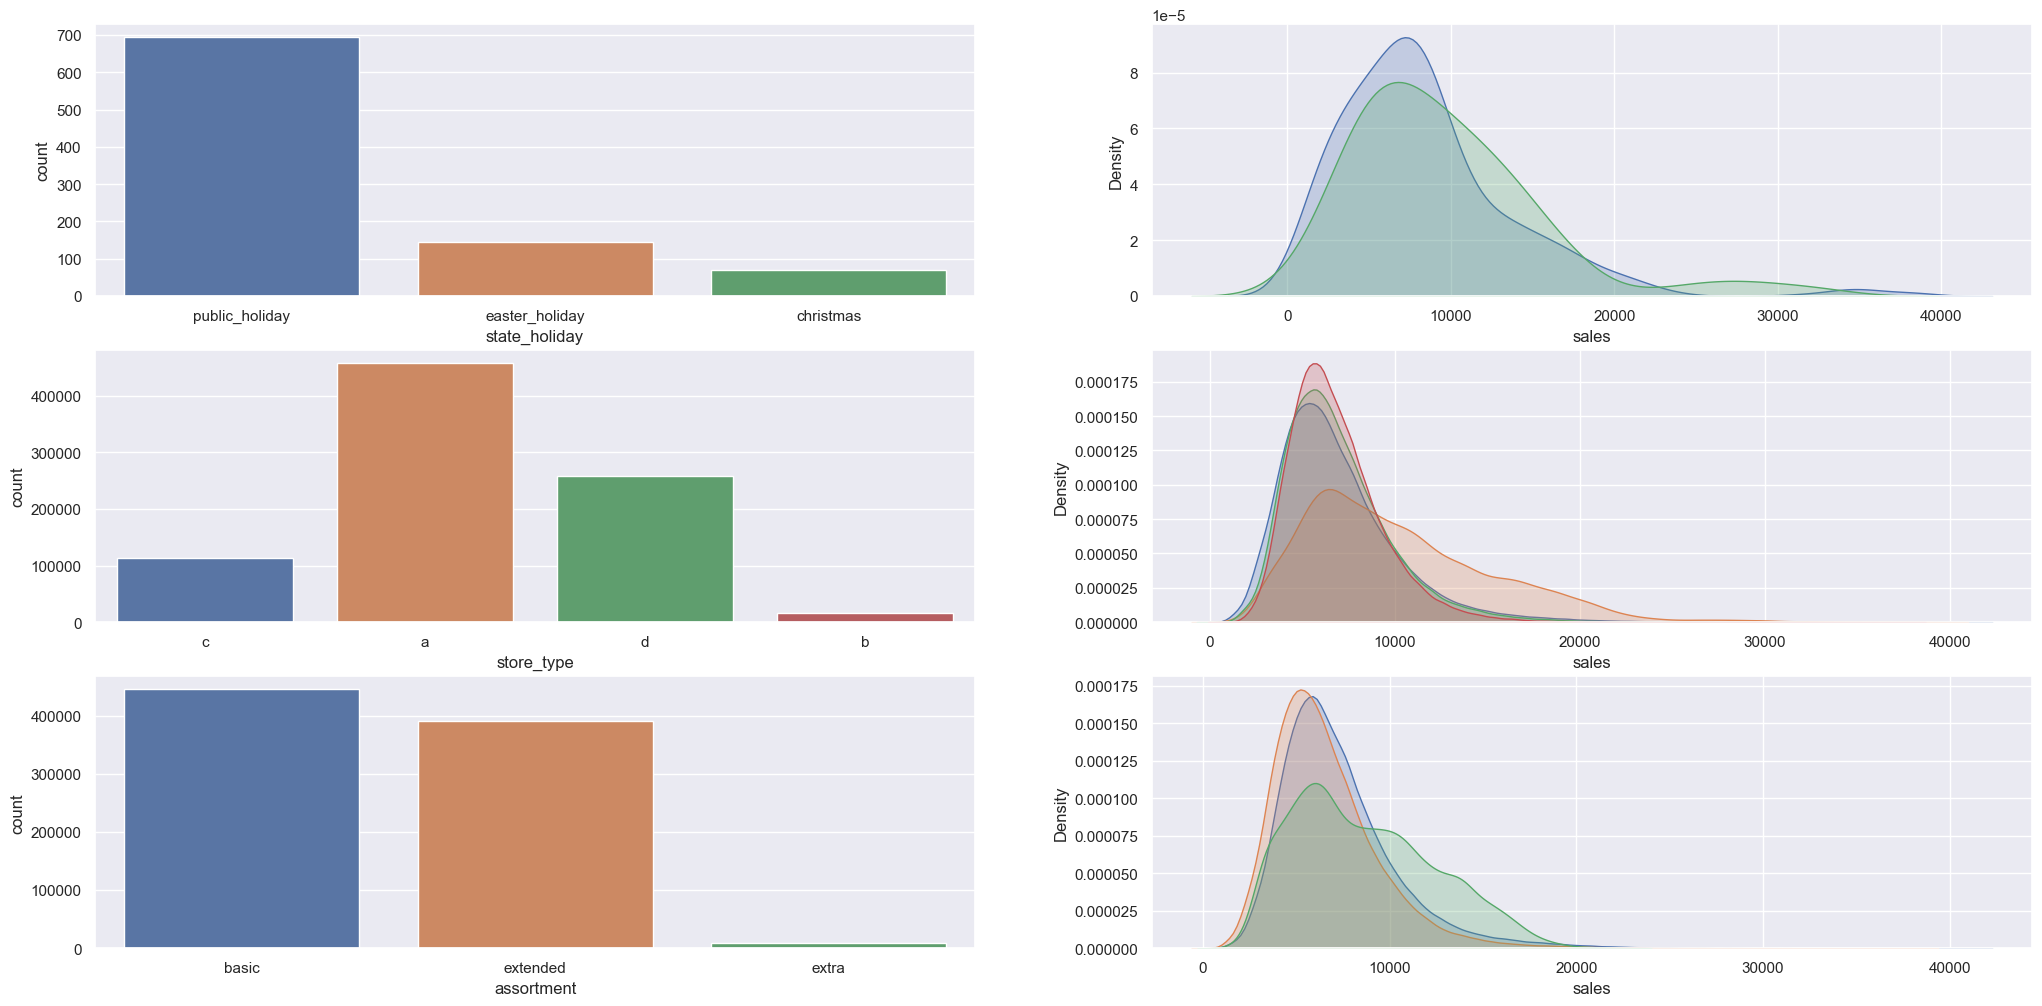

In [38]:
#state_holiday 

plt.subplot(3,2,1) #nº de linhas | nº de colunas | posiçõa 

a = df4[df4['state_holiday'] != 'regular_day']

sns.countplot( x= a['state_holiday']); 

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'state_holiday']['sales'], label = 'easter_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True)

#store_type 
plt.subplot(3,2,3) 
sns.countplot(x = df4['store_type'])

plt.subplot(3, 2, 4) 

sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill = True)

#assortment 
plt.subplot(3,2,5)
sns.countplot( x = df4['assortment']) 

plt.subplot(3, 2, 6)

sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill = True)

## 4.2 Análise Bivariada

## 4.3 Análise Multivariada

### h1. Lojas com maior sortimentos deveriam vender mais.

In [60]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'competition_since', 'competition_time_month',
       'promo_since', 'promo_time_week'],
      dtype='object')

<Axes: xlabel='week_of_year'>

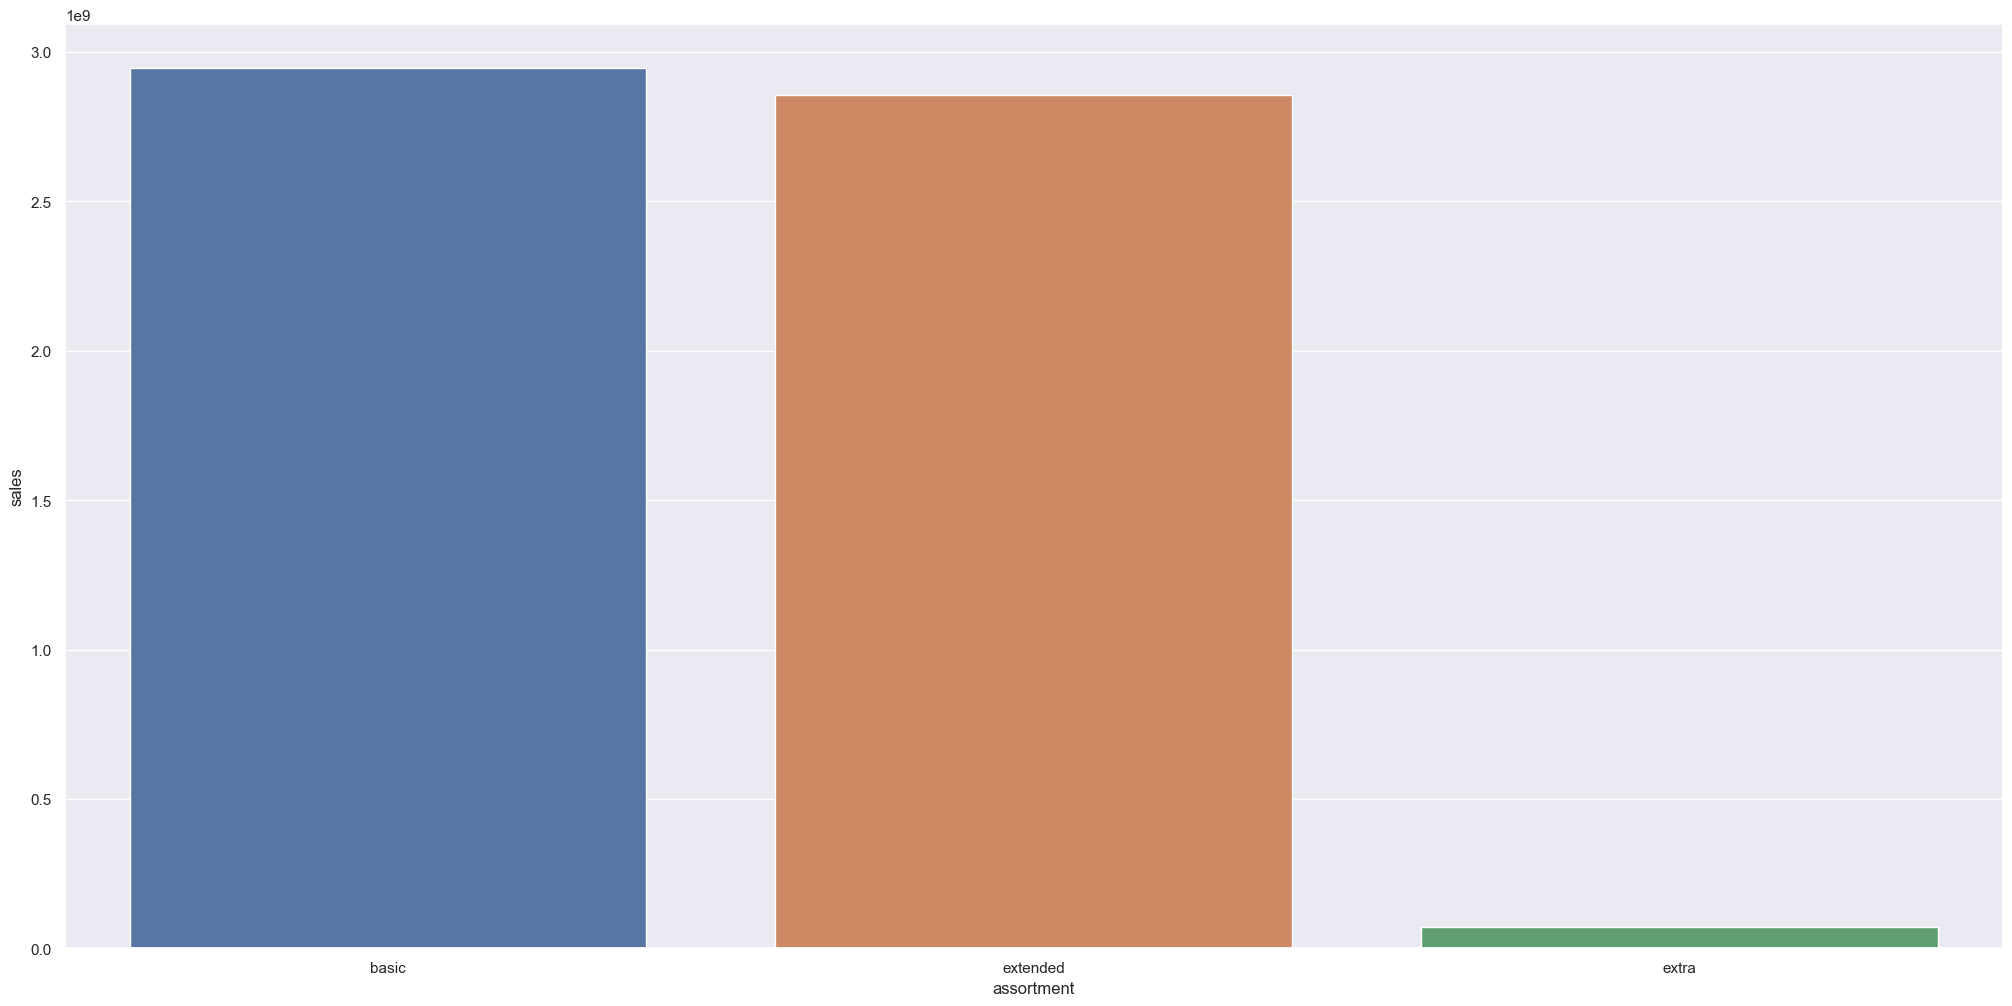

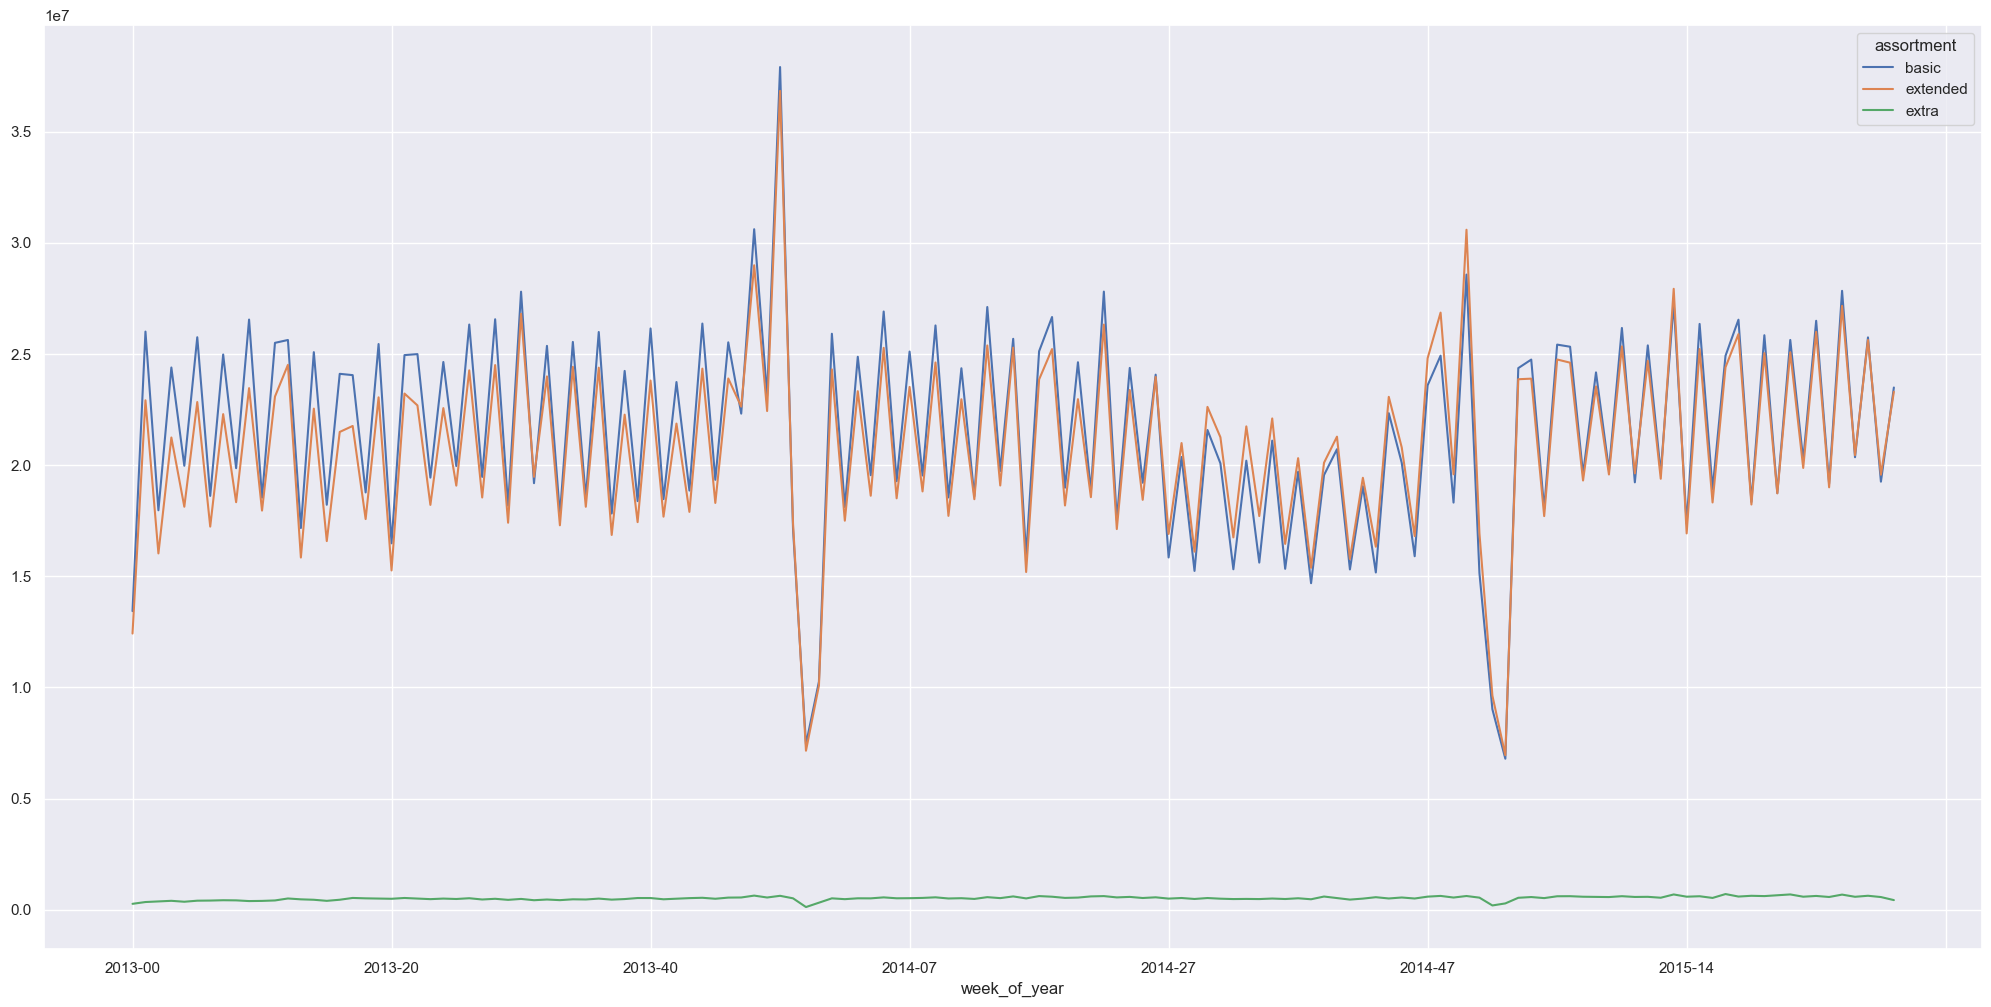

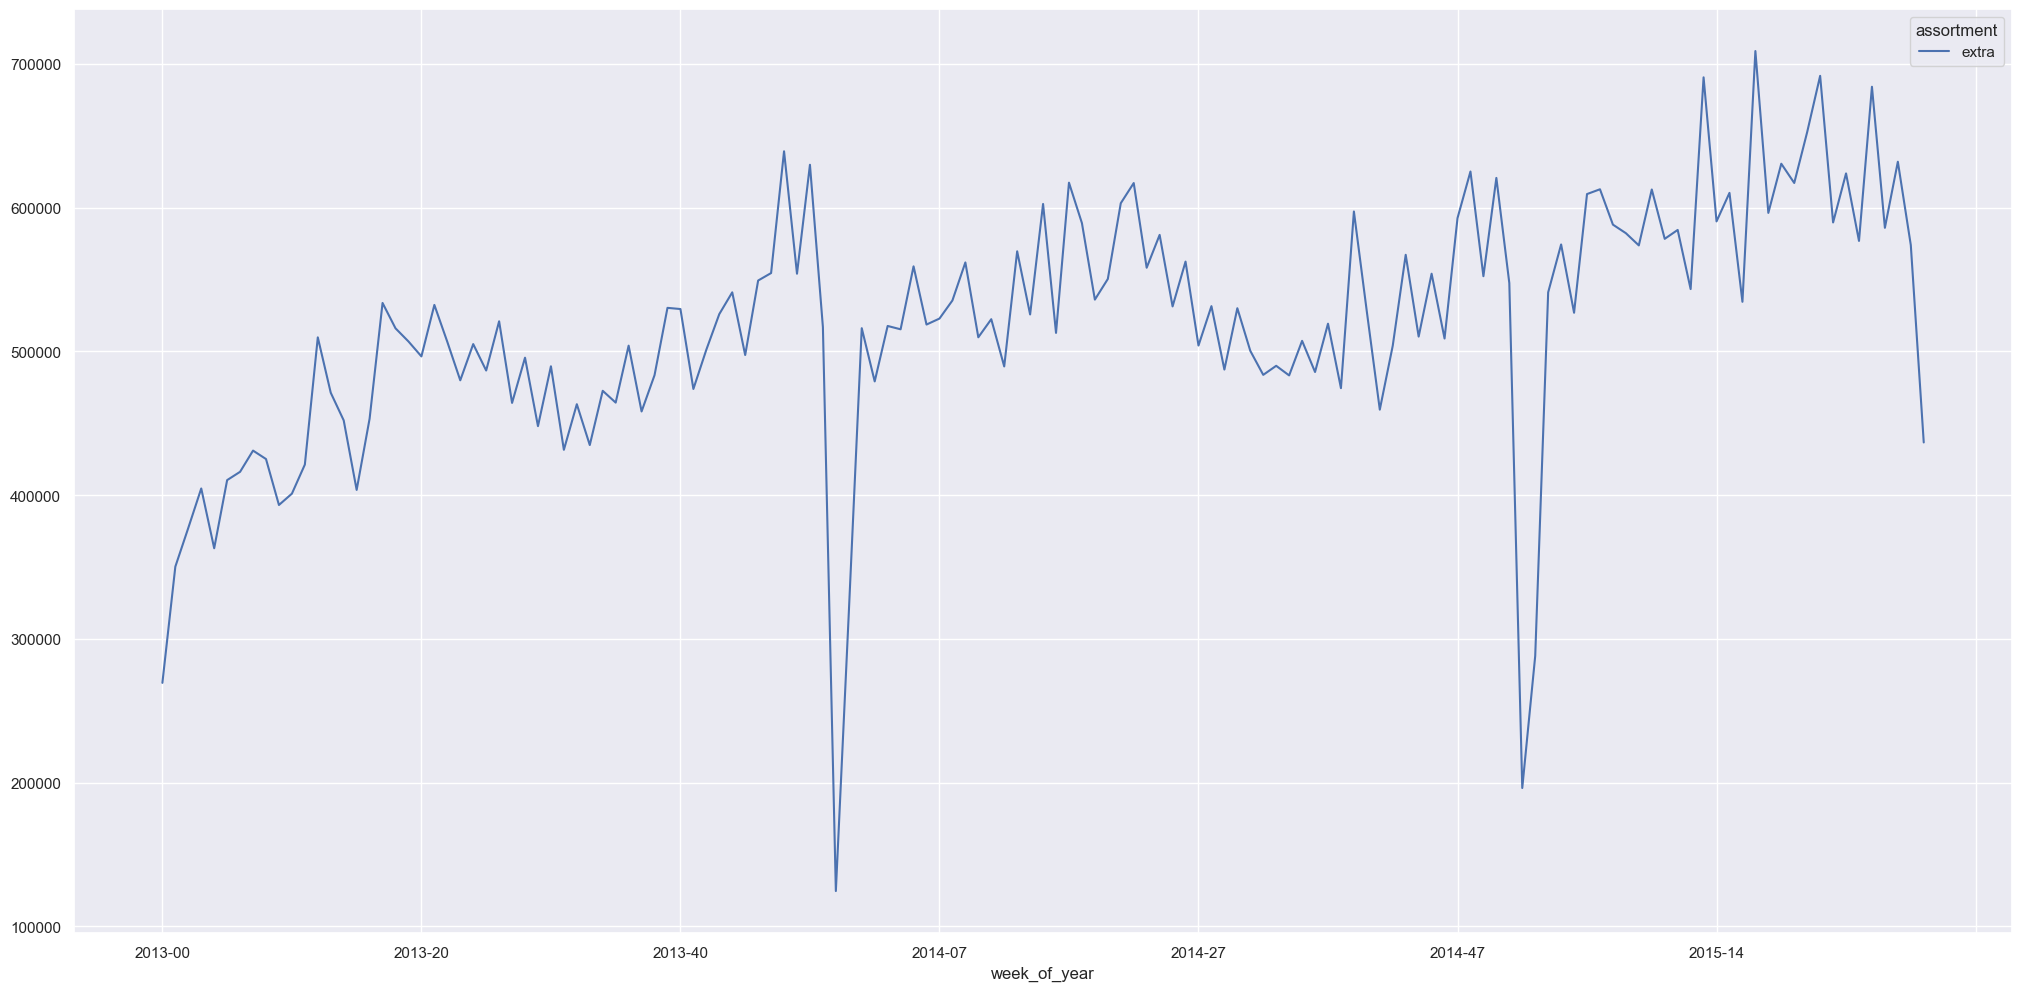

In [23]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['week_of_year', 'assortment', 'sales']].groupby(['week_of_year', 'assortment']).sum().reset_index()
aux3 = aux2.pivot(index = 'week_of_year', columns = 'assortment', values = 'sales').plot()

aux3  = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'week_of_year', columns = 'assortment', values = 'sales').plot() 

### h2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS VENDEM MAIS. 

C:\Users\Matheus\AppData\Local\Temp\ipykernel_3552\662830540.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap(aux1.corr(method='pearson'), annot = True);


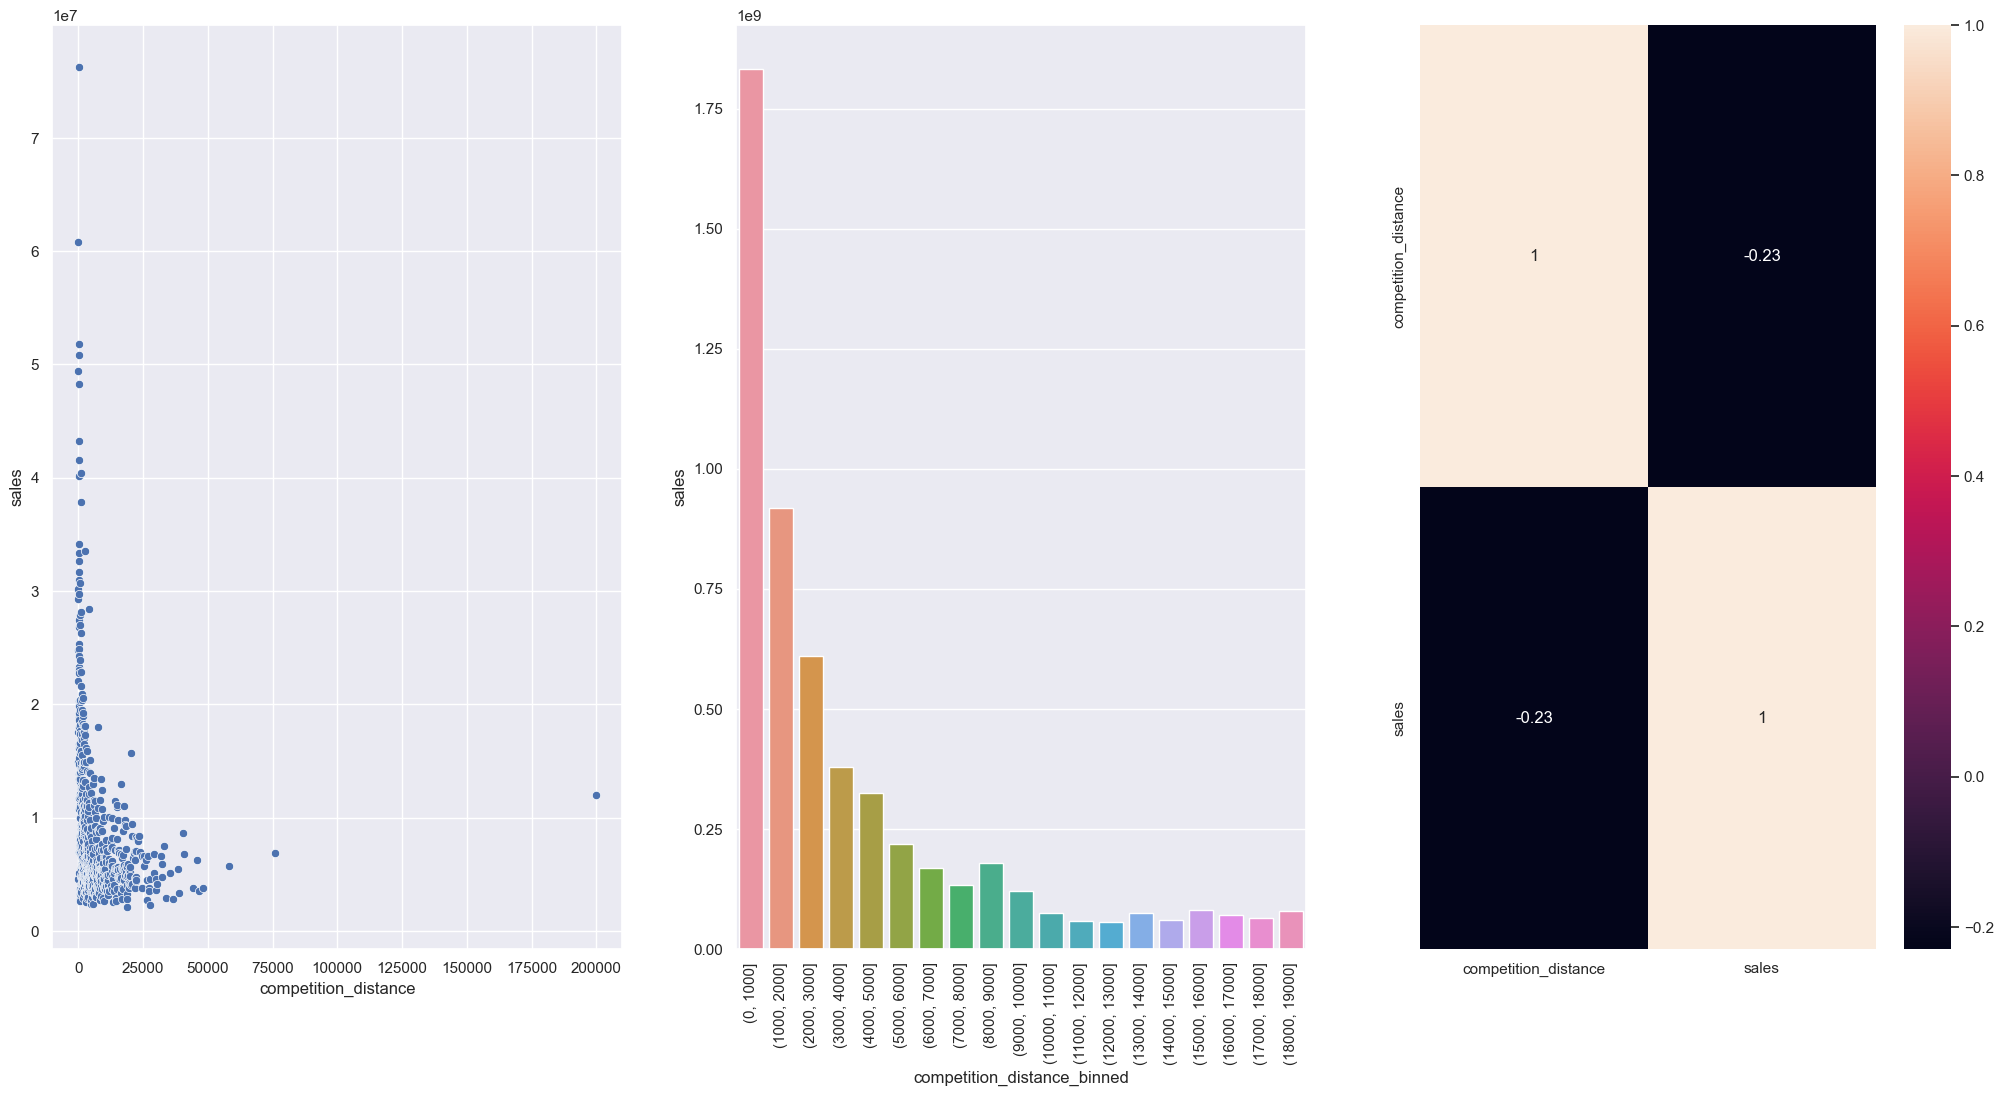

In [71]:
# FALSO: Lojas com competidores mais próximos vendem mais. 

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index() 

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1); 

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000)) # uma lista de 0 a 20000 pulando de 1000 a 1000. Bins são grupos de valores. 
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins) #pega os bins que eu criei e vai dizer em qual bin aquele valor pertence. 
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index() 
sns.barplot(x='competition_distance_binned', y='sales', data=aux2); 
plt.xticks(rotation=90);

plt.subplot(1, 3, 3) 
x = sns.heatmap(aux1.corr(method='pearson'), annot = True); #explicou nada. Apenas que é um heatmap de correlação. 


### h3. Lojas com competidores à mais tempo vendem mais
**Falsa** : Lojas com competidores a mais tempo vendem menos.

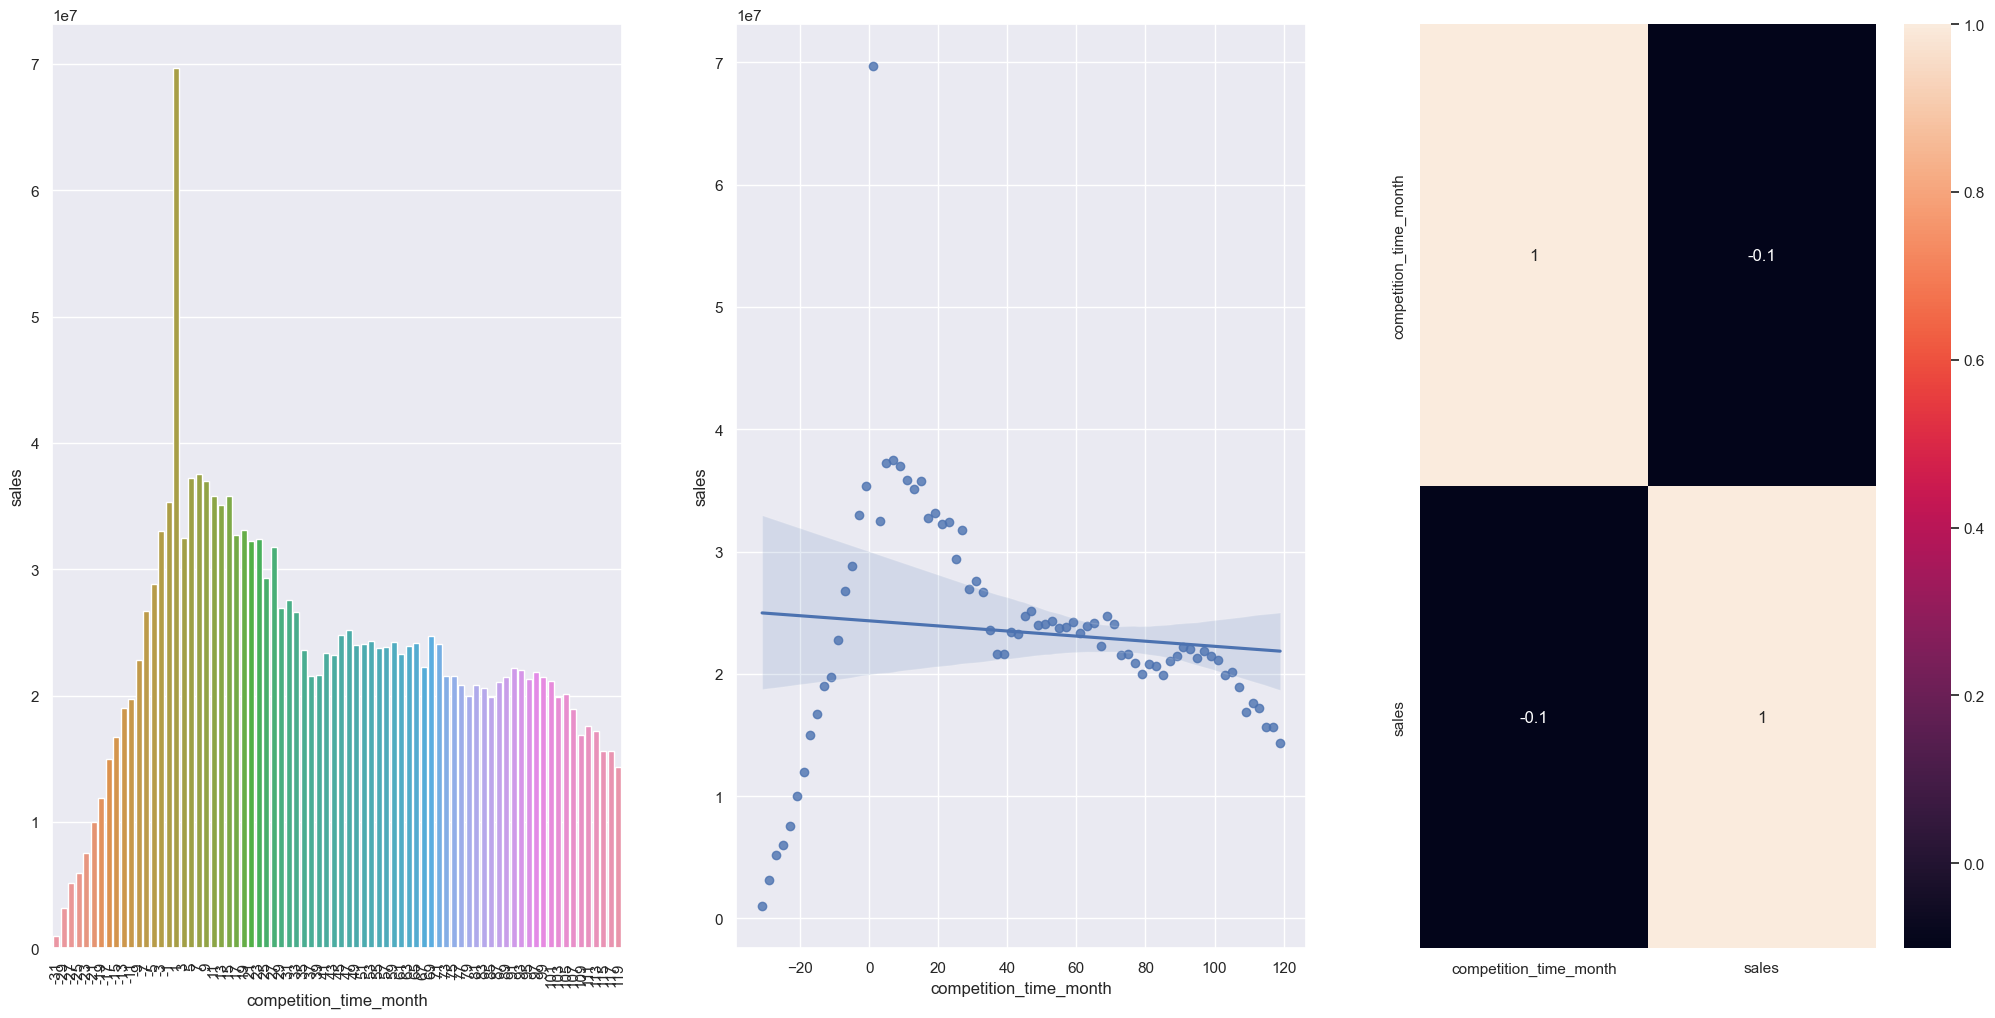

In [78]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & aux1['competition_time_month'] != 0]
sns.barplot(x ='competition_time_month', y= 'sales', data = aux2); 
plt.xticks(rotation=90);

#duração negativas referem-se quando o competidor abriu depois da data da compra registrada. 
#quanto mais se aproxima de zero, maior são as vendas. 

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y ='sales', data = aux2); 

plt.subplot(1, 3, 3) 
x = sns.heatmap(aux1.corr(method='pearson'), annot = True); 
#a correlação entre tempo de competição e as vendas (variável resposta) é -0.1 
#o tempo de competição é uma variável importante pro modelo porque tem uma correlação não tão próxima de zero assim. 

## H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa**: Pois lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.

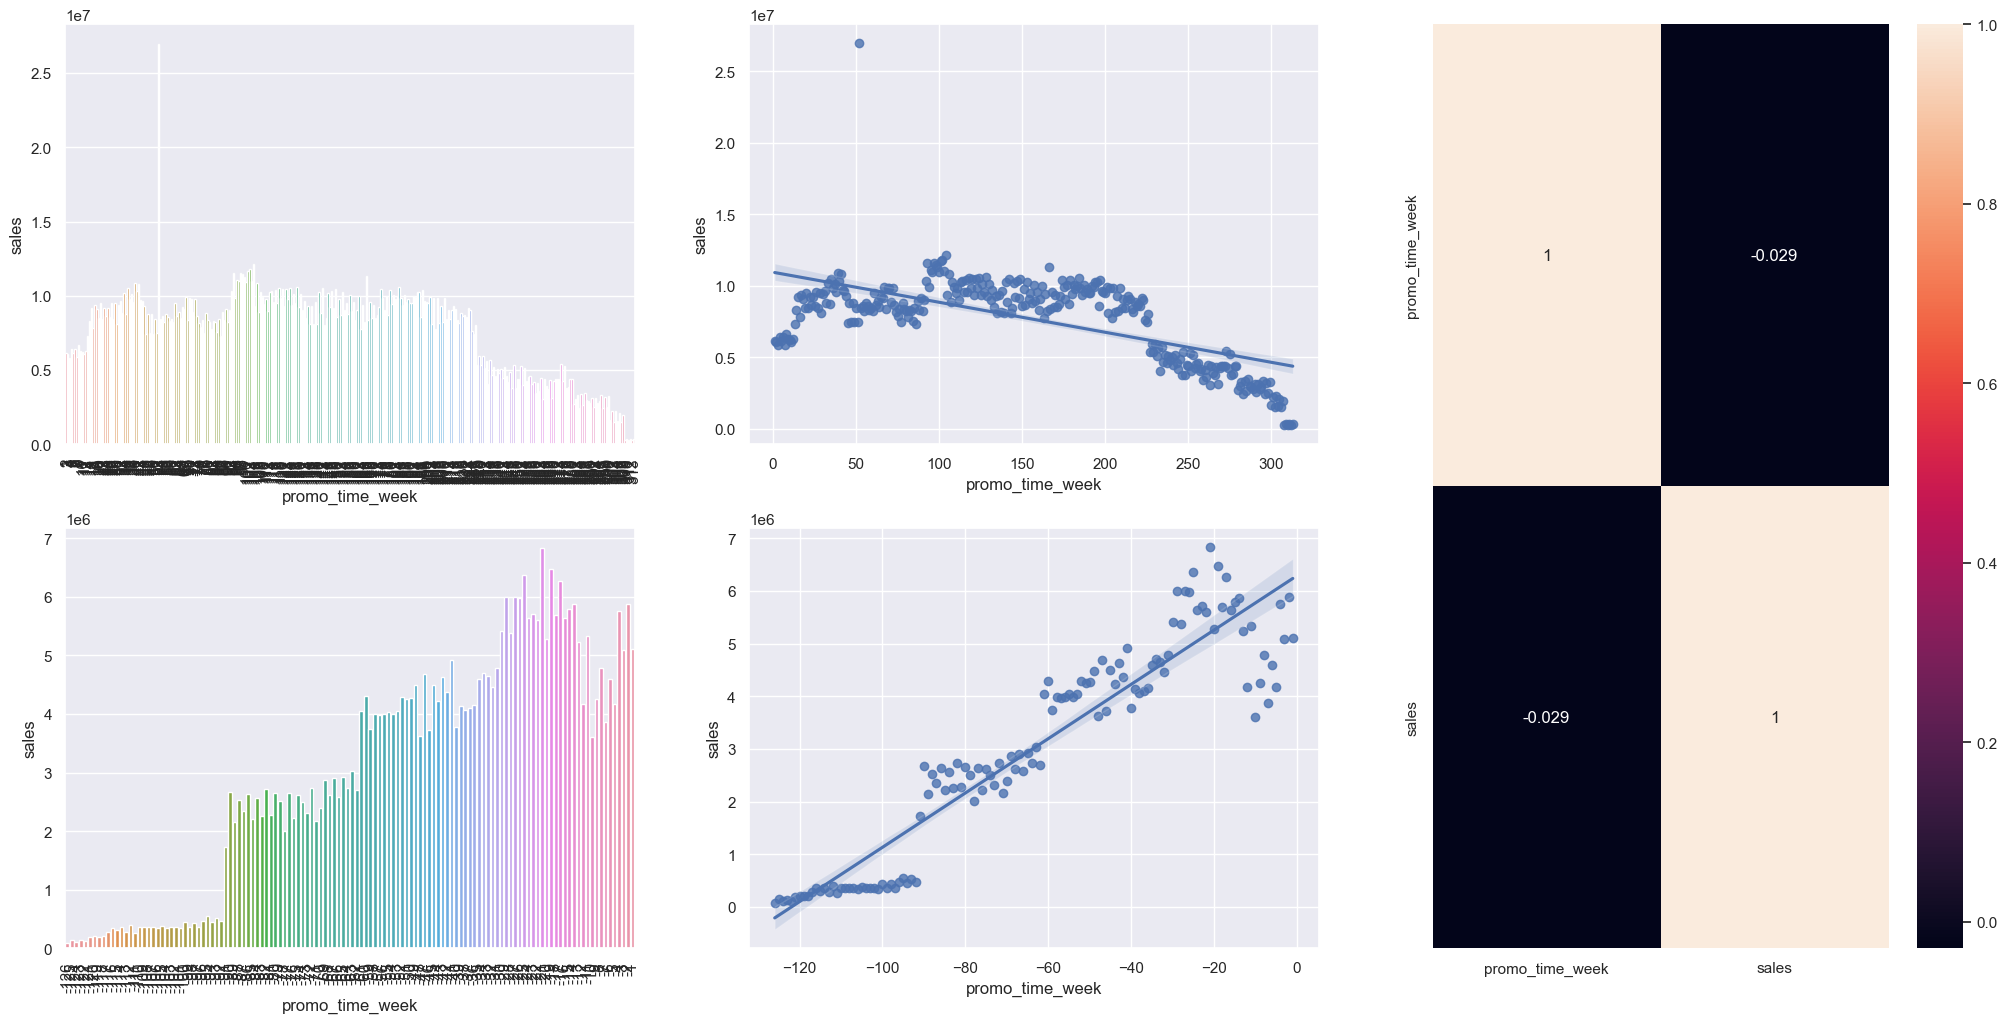

In [86]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3) #cria um objeto grid com 2 linhas e 3 colunas. 

#Como plotar direto o aux1 fica impossível de visualizar alguma coisa, "corta-se" os dados em duas partes
#A coluna promo_time_week foi feita levando em consideração:
#   Primeiro você tinha o período promocional tradicional e a loja escolhia se entrava no período de promoção extendido ou não. 
#   o promo_time_Week pega a diferença entre a data e o a data que começou a promoção extendida da loja. 
# se for positivo estamos na promoção extendida.
# se for negativo, estamos na promoção regular e a data que começará a extendida é uma data futura. 

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo_extendida 
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2); 
plt.xticks(rotation=90); 

plt.subplot(grid[0, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2); 

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular 
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3); 
plt.xticks(rotation=90);

plt.subplot(grid[1, 1]) 
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);  

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True); 

#percebe-se nos gráficos de baixo, uma tendência de crescimento, durante a promoção regular, provavelmente fruto do trabalho de marketing que divulga a promoção.
#entretanto, quanto entra-se na promoção extendida, temos uma tendência de decaimento das vendas.
#O que torna a hipóstese acima inválida. 


#O heatmap mostra uma correlação fraca da feature com a variável resposta, através do coeficiente de 0,02. Isso se deve muito provavelmente pelo grande período constante nos gráficos,
#sem uma tendência acentuada de crescimento ou decaimento. 
#Então pro modelo, não será uma feature muito relevante. 

##<s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>

## H7. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA**: Lojas com promoções consecutivas vendem menos.

In [25]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


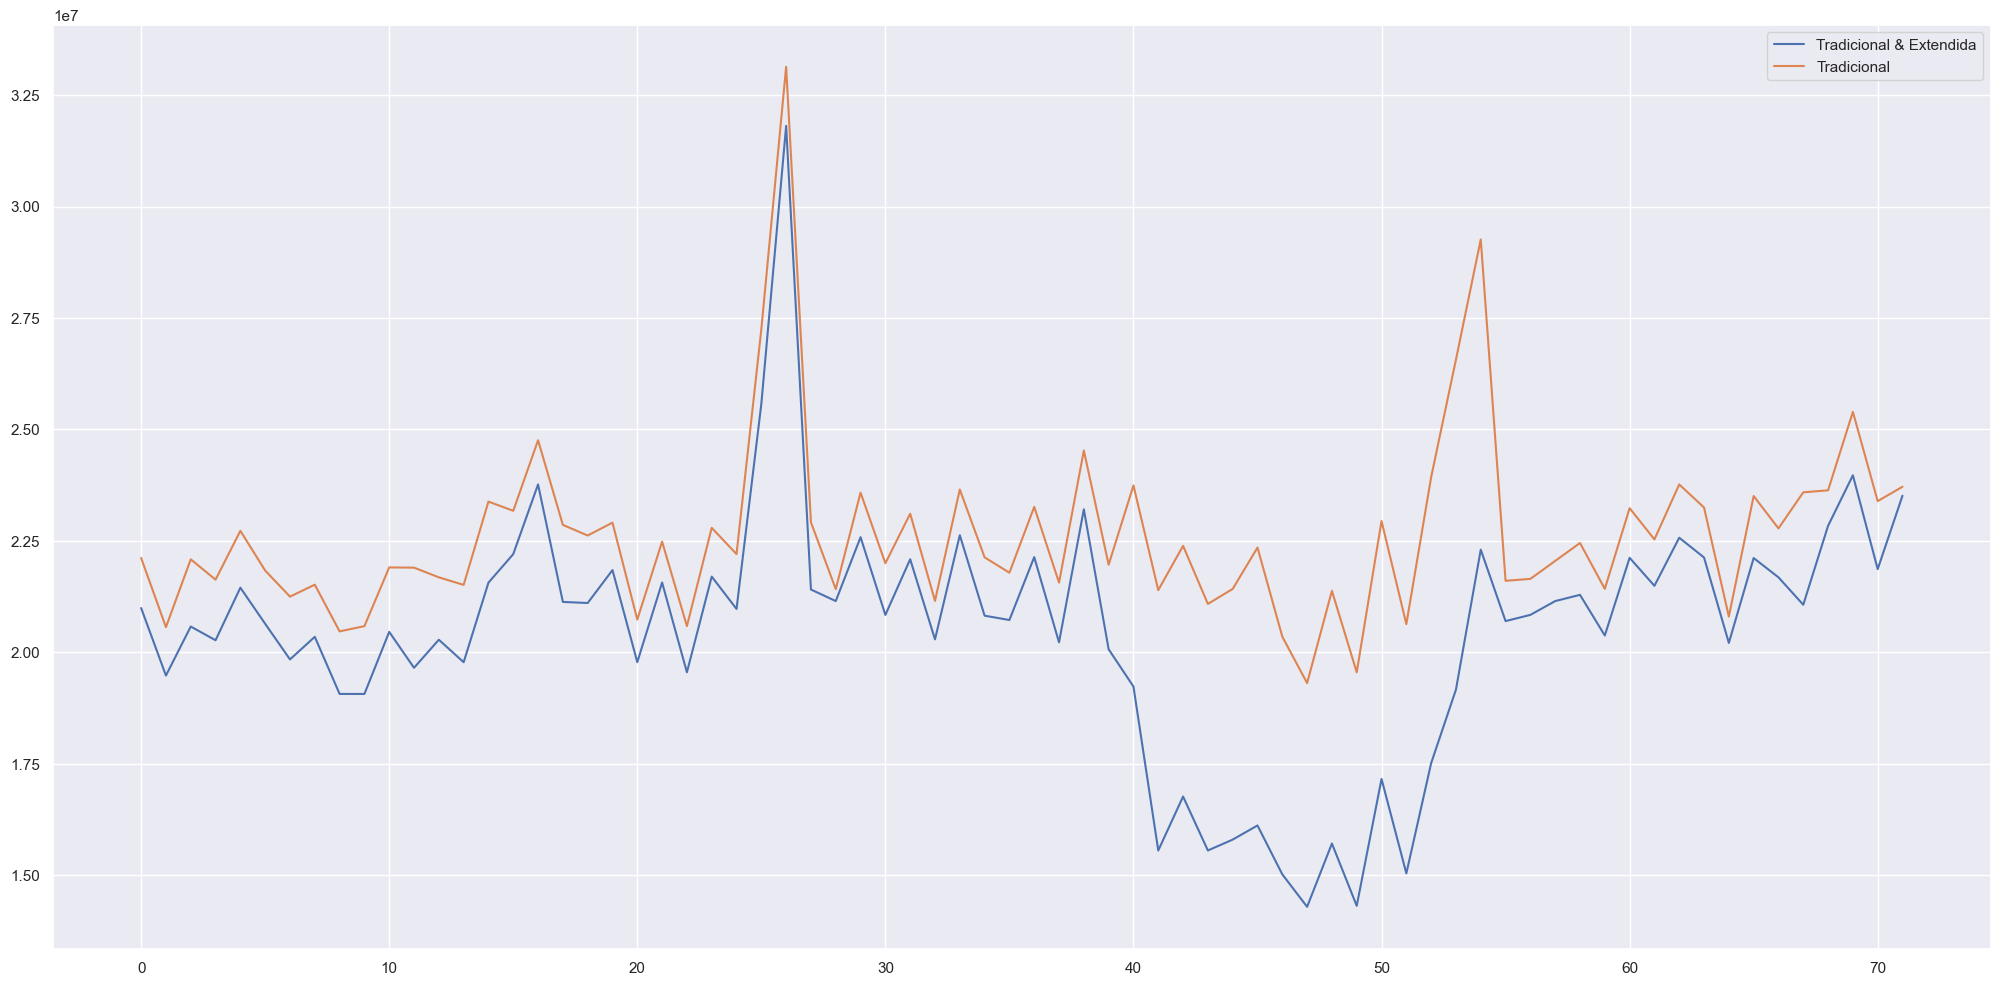

In [28]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
ax = aux1.plot() 

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
aux2.plot(ax = ax) #plotar no mesmo grid que acima 

ax.legend(labels = ['Tradicional & Extendida', 'Tradicional']); 

In [30]:
type(ax)

matplotlib.axes._axes.Axes